<a href="https://colab.research.google.com/github/ArwaASM/TPE/blob/main/Models_Evaluation_and_Confusion_Matrices_(RetinaNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Checking GPU Access**

In [ ]:
!nvidia-smi

Mon Nov 11 08:11:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## **Inatall Detectron2**

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.5 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-pp_wbs2d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-pp_wbs2d
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9131ce0e5bc0c89904541bc0355d933ccd6acbfb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# Detectron2 and necessary libraries
!pip install detectron2
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Other required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


## **Import our Dataset**

In [ ]:
!curl -L "https://app.roboflow.com/ds/YJev0eedEd?key=jafcYQcnNs" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3425      0 --:--:-- --:--:-- --:--:--  3438
100 29.4M  100 29.4M    0     0  32.5M      0 --:--:-- --:--:-- --:--:--  132M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0010_jpg.rf.20a99cec7de825bc38f7f75bf2904c21.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0017_jpg.rf.8d1e62e0299c5fcc5e33e70ea6df3f16.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0027_jpg.rf.80ca7d714fa4164c2d63ae5414f09f17.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0040_jpg.rf.908476d825252a8ea97df9a088a08410.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0076_jpg.rf.1e11ec3995f55e529c4adb0a8a1ea158.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0096_jpg.rf.846c195c082

## **Dataset Registration**

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")
register_coco_instances("my_dataset_valid", {}, "/content/valid/_annotations.coco.json", "/content/valid")

In [ ]:
test_dataset = "my_dataset_test"  # replace with your dataset name
metadata = MetadataCatalog.get(test_dataset)

## **Model Evaluation: RetinaNet_R_50**

In [ ]:
# Import necessary libraries
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
import os

# Define paths for your dataset
train_annotations_path = "/content/test/_annotations.coco.json"  # Path to your annotations in COCO format
train_images_path = "/content/test"  # Path to your images

# Register your dataset with Detectron2
dataset_name = "my_custom_test"
register_coco_instances(dataset_name, {}, train_annotations_path, train_images_path)

# Load the configuration for RetinaNet_R_50 and set it up for inference
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (dataset_name,)
cfg.DATASETS.TEST = (dataset_name,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR = "./OutputRetinaNet50Testm/"
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/output2_RetinaNet_50/model_final.pth"  # Path to your trained RetinaNet model checkpoint
cfg.MODEL.RETINANET.NUM_CLASSES = 11  # Set to the number of classes in your dataset
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # Adjust this threshold if needed
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 700  # This won't matter since we're not training

# Ensure output directory exists
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create an evaluator for your custom test dataset
evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

# Load the model without training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Build the test data loader for your custom dataset
test_loader = build_detection_test_loader(cfg, dataset_name)

# Run inference on the test dataset and evaluate
metrics = inference_on_dataset(trainer.model, test_loader, evaluator)

# Print the test dataset metrics
print("Test Dataset Metrics (without retraining):")
print(metrics)


WARNING [11/11 08:27:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/11 08:27:14 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
   

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

WARNING [11/11 08:27:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/11 08:27:15 d2.data.datasets.coco]: Loaded 453 images in COCO format from /content/test/_annotations.coco.json
[11/11 08:27:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/11 08:27:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/11 08:27:15 d2.data.common]: Serializing 453 elements to byte tensors and concatenating them all ...
[11/11 08:27:15 d2.data.common]: Serialized dataset takes 0.18 MiB
[11/11 08:27:15 d2.evaluation.evaluator]: Start inference on 453 batches
[11/11 08:27:15 d2.evaluation.evaluator]: Inference done 11/453. Dataloading: 0.0012 s/iter. Inference: 0.0237 s/iter. Eval: 0.0003 s/iter. Total: 0.0252 s/iter. ETA=0:00:11
[11/11 08:27:20 d2.evaluation.e

## **Generate Confusion Matrix_RetinaNet_R_50**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.68s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

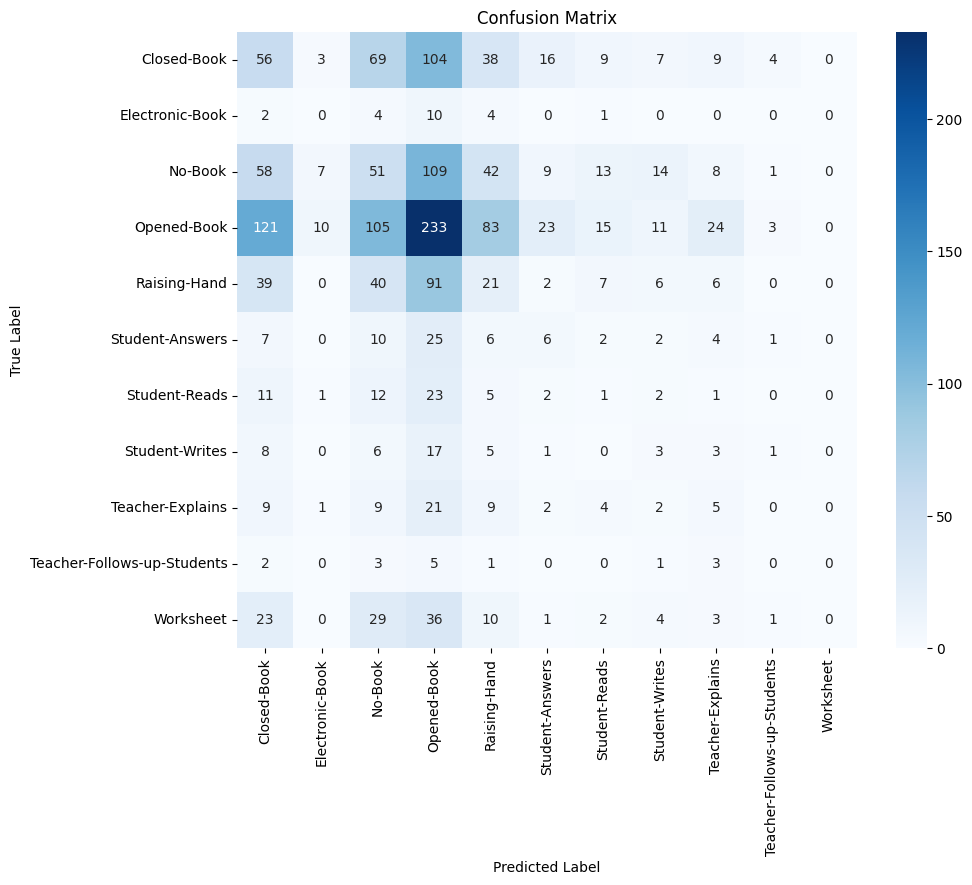

                             precision    recall  f1-score   support

                Closed-Book       0.17      0.18      0.17       315
            Electronic-Book       0.00      0.00      0.00        21
                    No-Book       0.15      0.16      0.16       312
                Opened-Book       0.35      0.37      0.36       628
               Raising-Hand       0.09      0.10      0.10       212
            Student-Answers       0.10      0.10      0.10        63
              Student-Reads       0.02      0.02      0.02        58
             Student-Writes       0.06      0.07      0.06        44
           Teacher-Explains       0.08      0.08      0.08        62
Teacher-Follows-up-Students       0.00      0.00      0.00        15
                  Worksheet       0.00      0.00      0.00       109

                   accuracy                           0.20      1839
                  macro avg       0.09      0.10      0.09      1839
               weighted avg     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

# Load ground truth and predictions
coco_gt = COCO('/content/test/_annotations.coco.json')
coco_dt = coco_gt.loadRes('/content/OutputRetinaNet50Testm/coco_instances_results.json')

# Category mapping
category_mapping = {
    1: 'Closed-Book', 2: 'Electronic-Book', 3: 'No-Book', 4: 'Opened-Book', 5: 'Raising-Hand',
    6: 'Student-Answers', 7: 'Student-Reads', 8: 'Student-Writes', 9: 'Teacher-Explains',
    10: 'Teacher-Follows-up-Students', 11: 'Worksheet'
}

# Perform COCO evaluation (for mAP and IoU)
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract mAP and AR for further analysis
mAP_50_95 = coco_eval.stats[0]  # mAP @ [0.5:0.95]
mAP_50 = coco_eval.stats[1]      # mAP @ 0.50
average_recall = coco_eval.stats[8]

# Initialize lists for true and predicted labels
true_labels = []
pred_labels = []

# Extract true labels from ground truth annotations and predicted labels from detection results
for img_id in coco_gt.getImgIds():
    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)

    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dts = coco_dt.loadAnns(dt_ids)

    # Add ground truth and predicted labels to the lists
    # Ensure each ground truth annotation corresponds to a prediction
    for ann in anns:
        true_labels.append(ann['category_id'])

    # Filter out predictions that don't have corresponding ground truth
    for dt in dts:
        # Only add predicted labels if they have a corresponding ground truth
        pred_labels.append(dt['category_id'])

# Handle mismatched lengths by trimming the longer list (if needed)
min_length = min(len(true_labels), len(pred_labels))
true_labels_trimmed = true_labels[:min_length]
pred_labels_trimmed = pred_labels[:min_length]

# Generate the confusion matrix based on category ids
conf_matrix = confusion_matrix(true_labels_trimmed, pred_labels_trimmed, labels=list(category_mapping.keys()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

# Classification report (Precision, Recall, F1-score per class)
print(classification_report(true_labels_trimmed, pred_labels_trimmed, target_names=category_mapping.values(), labels=list(category_mapping.keys())))

# IoU Calculation Function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union = box1_area + box2_area - intersection

    iou = intersection / union if union != 0 else 0
    return iou

# Example bounding boxes
box1 = [100, 150, 200, 250]
box2 = [120, 170, 220, 270]

# Calculate IoU between box1 and box2
iou = compute_iou(box1, box2)
print(f"IoU between two boxes: {iou}")


In [ ]:
# Import necessary libraries
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import os
import cv2

# Define paths for your dataset
test_annotations_path = "/content/test/_annotations.coco.json"  # Path to your test annotations in COCO format
test_images_path = "/content/test"  # Path to your test images

# Register your dataset with Detectron2
dataset_name = "my_custom_test"
register_coco_instances(dataset_name, {}, test_annotations_path, test_images_path)

# Load the configuration for RetinaNet_R_50 and set it up for inference
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TEST = (dataset_name,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/output2_RetinaNet_50/model_final.pth"  # Path to your trained RetinaNet model checkpoint
cfg.MODEL.RETINANET.NUM_CLASSES = 11  # Set to the number of classes in your dataset
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # Adjust this threshold if needed

# Create a predictor for inference
predictor = DefaultPredictor(cfg)

# Set the output directory for saving inference images
output_dir = "./inference_resultsRe50/"
os.makedirs(output_dir, exist_ok=True)

# Get metadata for visualizing predictions
metadata = MetadataCatalog.get(dataset_name)

# Iterate through all images in the test dataset directory
for image_name in os.listdir(test_images_path):
    # Check if the file is an image
    if image_name.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Adjust image formats as necessary
        # Load the image
        image_path = os.path.join(test_images_path, image_name)
        img = cv2.imread(image_path)

        if img is None:
            print(f"Error: Could not read image {image_name}")
            continue

        # Perform inference
        outputs = predictor(img)

        # Visualize predictions
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
        vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

        # Save the output image with bounding boxes
        output_image_path = os.path.join(output_dir, f"pred_{image_name}")
        cv2.imwrite(output_image_path, vis.get_image()[:, :, ::-1])

print(f"Inference results saved to: {output_dir}")


[11/11 08:32:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/output2_RetinaNet_50/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Inference results saved to: ./inference_resultsRe50/


## **Model Evaluation: RetinaNet_R_101**

In [ ]:
# Import necessary libraries
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
import os

# Define paths for your dataset
train_annotations_path = "/content/test/_annotations.coco.json"  # Path to your annotations in COCO format
train_images_path = "/content/test"  # Path to your images

# Register your dataset with Detectron2
dataset_name = "my_custom_test"
register_coco_instances(dataset_name, {}, train_annotations_path, train_images_path)

# Load the configuration for RetinaNet_R_50 and set it up for inference
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (dataset_name,)
cfg.DATASETS.TEST = (dataset_name,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR = "./OutputRetinaNet101Testm/"
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/RetinaNet_101_FPN_3x/output2/model_final.pth"  # Path to your trained RetinaNet model checkpoint
cfg.MODEL.RETINANET.NUM_CLASSES = 11  # Set to the number of classes in your dataset
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # Adjust this threshold if needed
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 700  # This won't matter since we're not training

# Ensure output directory exists
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create an evaluator for your custom test dataset
evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

# Load the model without training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Build the test data loader for your custom dataset
test_loader = build_detection_test_loader(cfg, dataset_name)

# Run inference on the test dataset and evaluate
metrics = inference_on_dataset(trainer.model, test_loader, evaluator)

# Print the test dataset metrics
print("Test Dataset Metrics (without retraining):")
print(metrics)


WARNING [11/11 08:42:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/11 08:42:26 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
   

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

WARNING [11/11 08:42:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/11 08:42:30 d2.data.datasets.coco]: Loaded 453 images in COCO format from /content/test/_annotations.coco.json
[11/11 08:42:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/11 08:42:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/11 08:42:30 d2.data.common]: Serializing 453 elements to byte tensors and concatenating them all ...
[11/11 08:42:30 d2.data.common]: Serialized dataset takes 0.18 MiB
[11/11 08:42:30 d2.evaluation.evaluator]: Start inference on 453 batches
[11/11 08:42:31 d2.evaluation.evaluator]: Inference done 11/453. Dataloading: 0.0012 s/iter. Inference: 0.0310 s/iter. Eval: 0.0003 s/iter. Total: 0.0326 s/iter. ETA=0:00:14
[11/11 08:42:36 d2.evaluation.e

## **Generate Confusion Matrix_RetinaNet_R_101**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

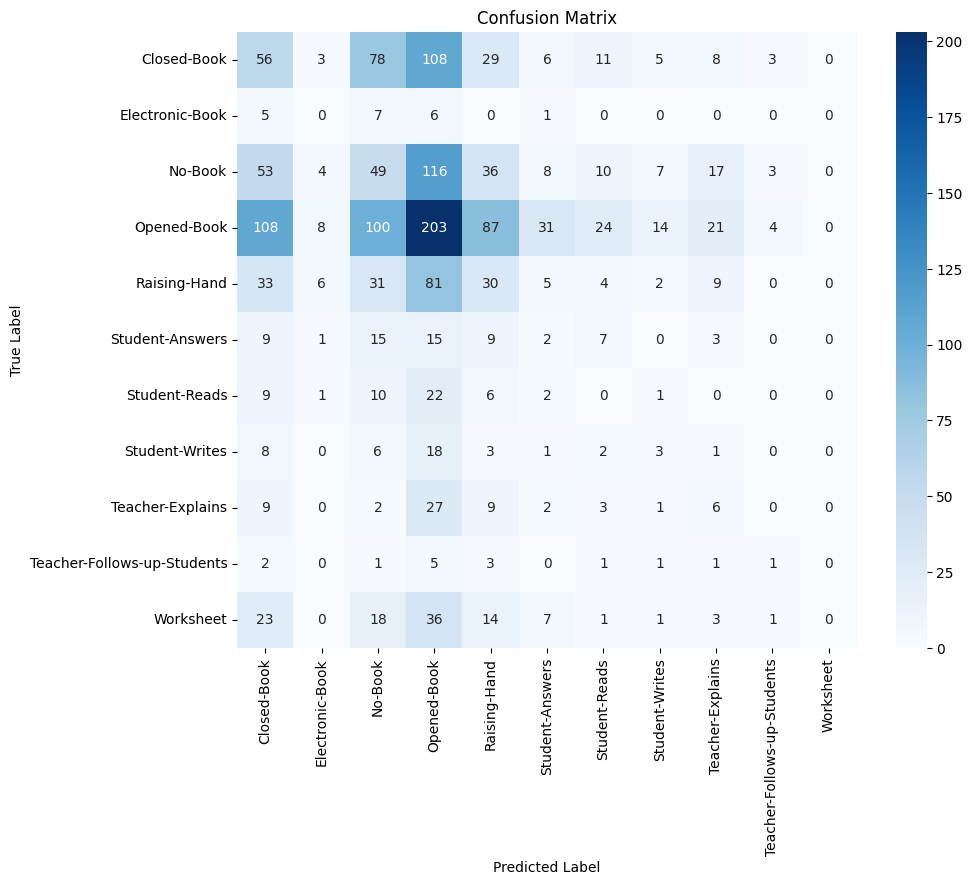

                             precision    recall  f1-score   support

                Closed-Book       0.18      0.18      0.18       307
            Electronic-Book       0.00      0.00      0.00        19
                    No-Book       0.15      0.16      0.16       303
                Opened-Book       0.32      0.34      0.33       600
               Raising-Hand       0.13      0.15      0.14       201
            Student-Answers       0.03      0.03      0.03        61
              Student-Reads       0.00      0.00      0.00        51
             Student-Writes       0.09      0.07      0.08        42
           Teacher-Explains       0.09      0.10      0.09        59
Teacher-Follows-up-Students       0.08      0.07      0.07        15
                  Worksheet       0.00      0.00      0.00       104

                   accuracy                           0.20      1762
                  macro avg       0.10      0.10      0.10      1762
               weighted avg     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

# Load ground truth and predictions
coco_gt = COCO('/content/test/_annotations.coco.json')
coco_dt = coco_gt.loadRes('/content/OutputRetinaNet101Testm/coco_instances_results.json')

# Category mapping
category_mapping = {
    1: 'Closed-Book', 2: 'Electronic-Book', 3: 'No-Book', 4: 'Opened-Book', 5: 'Raising-Hand',
    6: 'Student-Answers', 7: 'Student-Reads', 8: 'Student-Writes', 9: 'Teacher-Explains',
    10: 'Teacher-Follows-up-Students', 11: 'Worksheet'
}

# Perform COCO evaluation (for mAP and IoU)
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract mAP and AR for further analysis
mAP_50_95 = coco_eval.stats[0]  # mAP @ [0.5:0.95]
mAP_50 = coco_eval.stats[1]      # mAP @ 0.50
average_recall = coco_eval.stats[8]

# Initialize lists for true and predicted labels
true_labels = []
pred_labels = []

# Extract true labels from ground truth annotations and predicted labels from detection results
for img_id in coco_gt.getImgIds():
    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)

    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dts = coco_dt.loadAnns(dt_ids)

    # Add ground truth and predicted labels to the lists
    # Ensure each ground truth annotation corresponds to a prediction
    for ann in anns:
        true_labels.append(ann['category_id'])

    # Filter out predictions that don't have corresponding ground truth
    for dt in dts:
        # Only add predicted labels if they have a corresponding ground truth
        pred_labels.append(dt['category_id'])

# Handle mismatched lengths by trimming the longer list (if needed)
min_length = min(len(true_labels), len(pred_labels))
true_labels_trimmed = true_labels[:min_length]
pred_labels_trimmed = pred_labels[:min_length]

# Generate the confusion matrix based on category ids
conf_matrix = confusion_matrix(true_labels_trimmed, pred_labels_trimmed, labels=list(category_mapping.keys()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

# Classification report (Precision, Recall, F1-score per class)
print(classification_report(true_labels_trimmed, pred_labels_trimmed, target_names=category_mapping.values(), labels=list(category_mapping.keys())))

# IoU Calculation Function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union = box1_area + box2_area - intersection

    iou = intersection / union if union != 0 else 0
    return iou

# Example bounding boxes
box1 = [100, 150, 200, 250]
box2 = [120, 170, 220, 270]

# Calculate IoU between box1 and box2
iou = compute_iou(box1, box2)
print(f"IoU between two boxes: {iou}")
